## Driver code comparing different QC / OD lists 
- QC: manual / visual quality checks
- OD: automatic outlier detection 

### Steps
- import CSVs from QC / OD procedures
- compare overlap of subjects

In [118]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [119]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'

# Gleb / Marten visual QC
manual_outlier_file = qc_dir + 'master_QC_table.csv'

# Automated outliers
pipeline_outlier_file = outlier_dir + 'pipeline_outlier_data.csv'

aparc_outlier_file = outlier_dir + 'aparc_outlier_data.csv'
destr_outlier_file = outlier_dir + 'des_outlier_data.csv'
glass_outlier_file = outlier_dir + 'glas_outlier_data.csv'

highdim_lh_ctrl = outlier_dir + 'outlier_lh_con.csv'
highdim_rh_ctrl = outlier_dir + 'outlier_rh_con.csv'

outlier_file_dict = {'manual':manual_outlier_file,
                    'auto_pipline': pipeline_outlier_file,
                    'auto_aparc': aparc_outlier_file,
                    'auto_destr': destr_outlier_file,
                    'auto_glass': glass_outlier_file,
                    'auto_highdim_lh_ctrl':highdim_lh_ctrl,
                    'auto_highdim_rh_ctrl':highdim_rh_ctrl,}

# qc_criterion = ('QC_maarten',[0]) # keep subs
# qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
# qc_criterion = ('outlier_all_data',[0])

### Demographics of high-dim FS data

In [121]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
high_dim_file_subject_file = '/home/nikhil/projects/CT_reproduce/data/fs60_vertex_out/FS_vertex_output_subject_list.txt'
demograph_file = 'ABIDE_Phenotype.csv'

In [139]:
# Add demographic columns to the master_df
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str
useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].astype(int) 

subject_list = pd.read_csv(high_dim_file_subject_file,dtype={'SUB_ID': int})
subject_list = subject_list.rename(columns={'SUB_ID':subject_ID_col})

# Demograph of the high-dim subset
high_dim_demograph = useful_demograph[useful_demograph[subject_ID_col].isin(subject_list[subject_ID_col].values)]
for dx in [0,1]:
    df = high_dim_demograph[high_dim_demograph['DX_GROUP'] == dx]
    print(df['AGE_AT_SCAN'].mean(),df['AGE_AT_SCAN'].std())
    print(df['SEX'].value_counts())

16.878489483394834 7.74034950143841
0    444
1     98
Name: SEX, dtype: int64
17.239433267716535 8.476550503116766
0    446
1     62
Name: SEX, dtype: int64


### Global Var

In [120]:
subject_ID_col = 'SubjID'

In [54]:
outlier_data_dict = {}
for key in outlier_file_dict.keys():
    df = pd.read_csv(outlier_file_dict[key], dtype={'SubjID': int})
    if key == 'manual':
        df.loc[df['QC_maarten'] != 0.0, 'QC_maarten'] = 1.0
        df.loc[df['QC_gleb'] == '1', 'QC_gleb'] = 0.0
        df.loc[df['QC_gleb'] == '-+1', 'QC_gleb'] = 0.0
        df.loc[df['QC_gleb'] != 0.0, 'QC_gleb'] = 1.0
        
    outlier_data_dict[key] = df
    print('shape of QC file {}: {}'.format(key,df.shape))

shape of QC file auto_glass: (1047, 4)
shape of QC file auto_destr: (1047, 4)
shape of QC file auto_highdim_rh_ctrl: (542, 3)
shape of QC file manual: (1031, 6)
shape of QC file auto_highdim_lh_ctrl: (542, 3)
shape of QC file auto_pipline: (3890, 4)
shape of QC file auto_aparc: (1047, 4)


In [73]:
master_QC_OD_df = pd.DataFrame(columns=[subject_ID_col])
master_QC_OD_df[subject_ID_col] = outlier_data_dict['auto_aparc'][subject_ID_col]

# Manual
manual_df = outlier_data_dict['manual'][[subject_ID_col,'QC_maarten','QC_gleb']]
master_QC_OD_df = pd.merge(master_QC_OD_df, manual_df, on=subject_ID_col, how='left')

# Pipelines
pipe_df = outlier_data_dict['auto_pipline']
for pipe in pipe_df['pipeline'].unique():
    df = pipe_df[pipe_df['pipeline']==pipe][[subject_ID_col,'outlier_ind']]
    df = df.rename(columns={'outlier_ind':'OD_{}_DKT'.format(pipe)})
    master_QC_OD_df = pd.merge(master_QC_OD_df, df, on=subject_ID_col, how='left')

# Atlases
for atlas in ['aparc','destr','glass']:
    atlas_df = outlier_data_dict['auto_{}'.format(atlas)][[subject_ID_col,'outlier_all_data']]
    atlas_df = atlas_df.rename(columns={'outlier_all_data':'OD_FS6.0_{}'.format(atlas)})
    master_QC_OD_df = pd.merge(master_QC_OD_df, atlas_df, on=subject_ID_col, how='left')

# High-dim (outlier_ind)
for highdim in ['lh_ctrl','rh_ctrl']:
    highdim_df = outlier_data_dict['auto_highdim_{}'.format(highdim)][['SUB_ID','outlier_ind']]
    highdim_df = highdim_df.rename(columns={'SUB_ID':subject_ID_col,'outlier_ind':'OD_FS6.0_{}_outlier_ind'.format(highdim)})
    master_QC_OD_df = pd.merge(master_QC_OD_df, highdim_df, on=subject_ID_col, how='left')

In [111]:
master_QC_OD_df = master_QC_OD_df.fillna(1)
master_QC_OD_df['QC_sum'] = master_QC_OD_df[outlier_cols].sum(axis=1)

outlier_cols = ['QC_maarten', 'QC_gleb', 'ants_outlier_ind', 'civet_outlier_ind', 'fs51_outlier_ind', 
                'fs53_outlier_ind', 'fs60_outlier_ind', 'aparc_outlier_all_data', 'destr_outlier_all_data',
                'glass_outlier_all_data', 'lh_ctrl_outlier_ind', 'rh_ctrl_outlier_ind']



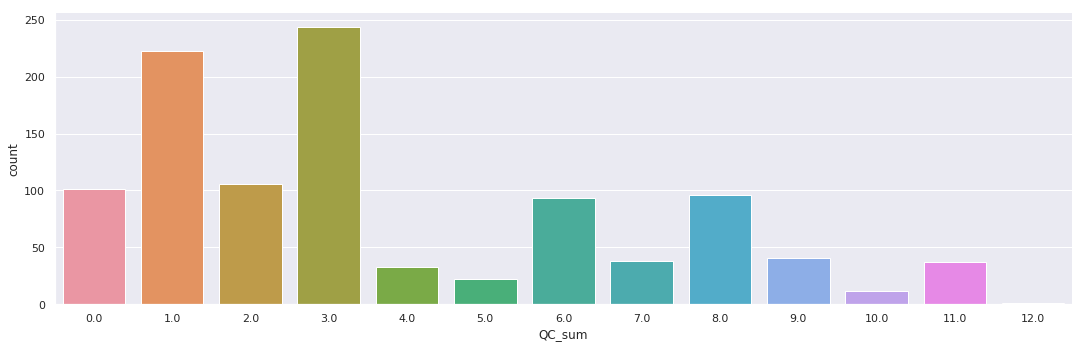

In [105]:
plot_df = master_QC_OD_df[outlier_cols]
with sns.axes_style("whitegrid"):
    sns.set(font_scale=1)
    g = sns.catplot(x='QC_sum',kind='count',aspect=3,data=plot_df)

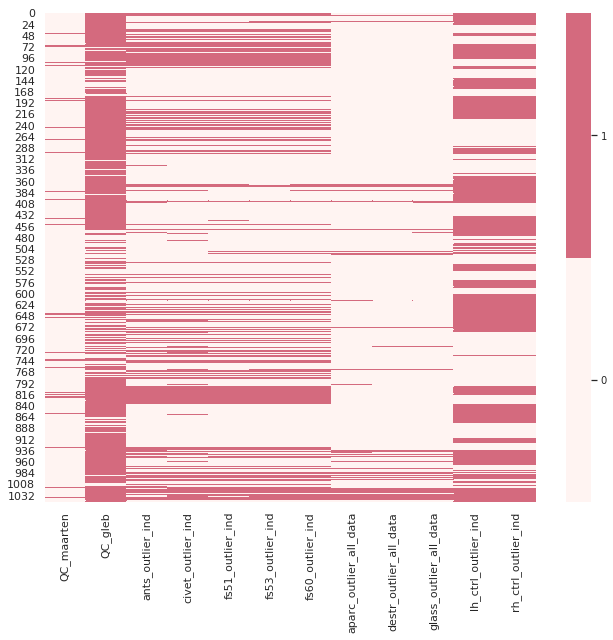

In [117]:
plot_df = master_QC_OD_df[outlier_cols]
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=1)
    g = sns.heatmap(plot_df, cmap=cmap)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=10)